# mkGPLVM in tensorflow
Very easy to use. A few lines is sufficient.

This update allow regularization and combining kernels on the same dimension. (What does it mean?)

Iteratively find the correct pattern.

In [34]:
%matplotlib inline

In [35]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np

import cyclum.tuning

cell_line = "H9"

# mkGPLVM implemented in Tensorflow

This is the implementation of mkGPLVM in Tensorflow.

# Get H9 data

In [36]:
raw_Y = pd.read_pickle('/home/shaoheng/Documents/data/McDavid/h9_df.pkl').T

cpt = pd.read_pickle('/home/shaoheng/Documents/data/McDavid/h9_cpt.pkl').values
print("Original dimesion %d cells x %d genes." % raw_Y.shape)
print(f"G0/G1 {sum(cpt == 'g0/g1')}, S {sum(cpt == 's')}, G2/M {sum(cpt == 'g2/m')}")

#expression_level = np.sum(2**raw_Y, axis=0)
#ind = np.argpartition(expression_level.values, -150)[-150:]
#genes = raw_Y.columns[np.argpartition(expression_level.values, -6)[-6:]]
#Y = raw_Y.loc[:, raw_Y.columns[ind]]
#Y.values[:, :] = preprocessing.scale(Y)

Y = preprocessing.scale(raw_Y)

N, D = Y.shape
print('After filtering %d Cells (instances) x %d Genes (features)'%(N, D))

Original dimesion 227 cells x 253 genes.
G0/G1 [66], S [68], G2/M [93]
After filtering 227 Cells (instances) x 253 Genes (features)


In [37]:
model = cyclum.tuning.CyclumAutoTune(Y, max_linear_dims=3, 
                                     epochs=2000, rate=5e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/2000, loss:  0.6687, time elapsed:  4.03s, time left:  76.53s
epoch: 200/2000, loss:  0.5600, time elapsed:  7.18s, time left:  64.66s
epoch: 300/2000, loss:  0.5082, time elapsed:  10.54s, time left:  59.70s
epoch: 400/2000, loss:  0.5006, time elapsed:  13.66s, time left:  54.63s
epoch: 500/2000, loss:  0.4907, time elapsed:  16.69s, time left:  50.08s
epoch: 600/2000, loss:  0.4893, time elapsed:  19.69s, time left:  45.95s
epoch: 700/2000, loss:  0.4913, time elapsed:  22.76s, time left:  42.27s
epoch: 800/2000, loss:  0.4863, time elapsed:  25.69s, time left:  38.53s
epoch: 900/2000, loss:  0.4897, time elapsed:  28.74s, time left:  35.13s
epoch: 1000/2000, loss:  0.4919, time elapsed:  31.71s, time left:  31.71s
epoch: 1100/2000, loss:  0.4898, time elapsed:  34.71s, time left:  28.40s
epoch: 1200/2000, loss:  0.4899, time elapsed:  37.71s, time left:  2

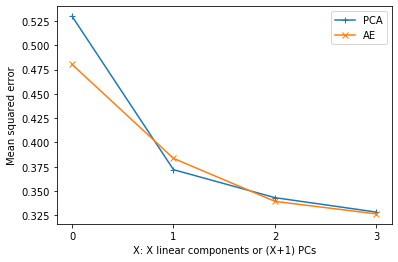

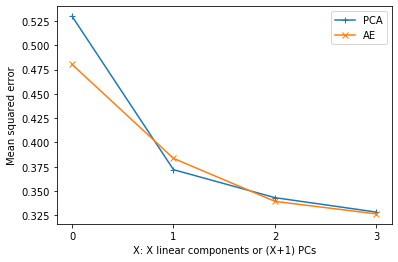

In [38]:
model.show_elbow()


In [39]:
import cyclum.models

model = cyclum.models.AutoEncoder(input_width=Y.shape[1],
                                  encoder_width=[30, 20], 
                                  encoder_depth=2,
                                 n_circular_unit=2,
                                 n_logistic_unit=0,
                                 n_linear_unit=0,
                                 n_linear_bypass=3,
                                 dropout_rate=0.1)


In [40]:
model.train(Y, epochs=1000, verbose=100, rate=2e-4)

epoch: 100/1000, loss:  0.3688, time elapsed:  4.64s, time left:  41.77s
epoch: 200/1000, loss:  0.3544, time elapsed:  7.90s, time left:  31.58s
epoch: 300/1000, loss:  0.3464, time elapsed:  11.30s, time left:  26.37s
epoch: 400/1000, loss:  0.3400, time elapsed:  14.63s, time left:  21.95s
epoch: 500/1000, loss:  0.3343, time elapsed:  18.10s, time left:  18.10s
epoch: 600/1000, loss:  0.3317, time elapsed:  21.62s, time left:  14.41s
epoch: 700/1000, loss:  0.3299, time elapsed:  25.07s, time left:  10.74s
epoch: 800/1000, loss:  0.3293, time elapsed:  28.59s, time left:  7.15s
epoch: 900/1000, loss:  0.3290, time elapsed:  32.03s, time left:  3.56s
epoch: 1000/1000, loss:  0.3280, time elapsed:  35.31s, time left:  0.00s


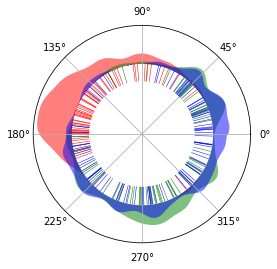

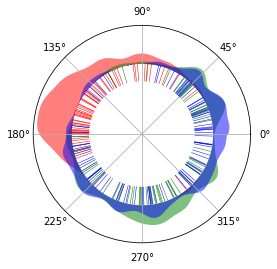

In [41]:
pseudotime = model.predict_pseudotime(Y)

import cyclum.illustration
color_map = {"g0/g1": "red", "s": "green", "g2/m": "blue"}
cyclum.illustration.plot_round_distr_color(pseudotime[:, 0], cpt.squeeze(), color_map)

(0, 3.141592653589793)

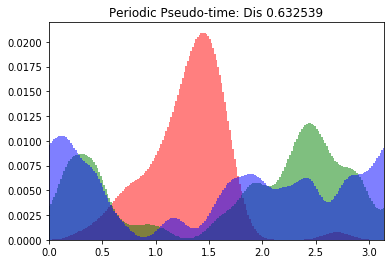

In [42]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
import cyclum.evaluation

width = 3.14 / 100 / 2;

discrete_time, distr_g0g1 = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g0/g1', 0])
plt.bar(discrete_time, distr_g0g1, color='red', alpha=0.5, width = width)

discrete_time, distr_s = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='s', 0])
plt.bar(discrete_time, distr_s, color='green', alpha=0.5, width = width)

discrete_time, distr_g2m = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g2/m', 0])
plt.bar(discrete_time, distr_g2m, color='blue', alpha=0.5, width = width)

correct_prob = cyclum.evaluation.precision_estimate([distr_g0g1, distr_s, distr_g2m], cpt, ['g0/g1', 's', 'g2/m'])
dis_score = correct_prob
plt.title("Periodic Pseudo-time: Dis %f" % dis_score)
plt.xlim([0, np.pi])

Note that this metric, although similar, is not exactly the same as the one we reported using mclust in R.

We use a non-parametric parzen window method to estimate the distribution here, 
while mclust uses a parametric normal mixture.

In [43]:
from cyclum.hdfrw import mat2hdf

mat2hdf(pseudotime, '/home/shaoheng/Documents/data/McDavid/h9-pseudotime.h5')

In [44]:
layer = model.model.get_layer('decoder_out')
weights = layer.get_weights()[0]
mat2hdf(weights, "/home/shaoheng/Documents/data/McDavid/h9-weight.h5")